In [2]:
import pandas as pd
import os
import numpy as np

import matplotlib.pyplot as plt

import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

from fbprophet import Prophet
from fbprophet.diagnostics import cross_validation
from fbprophet.diagnostics import performance_metrics
from fbprophet.plot import plot_cross_validation_metric

from scipy import stats
import math

import seaborn as sns
colors = ['lightcoral', 'sandybrown', 'orange', 'olive', 'darkseagreen', 'dodgerblue', 'mediumpurple', 'hotpink']
sns.set_style("whitegrid")
sns.set(rc={'figure.figsize':(14,9)})
sns.set(rc={'grid.alpha':0.75})
# sns.set(rc={'axes.facecolor':'white', 'figure.facecolor':'white'})

## Get Data

In [3]:
path_notebook = os.path.abspath('forecast_folsom_bouldercreek.ipynb')
dirname = os.path.dirname(path_notebook)


###########################
# Each table contains the columns: date, nb(northbound count), sb(southbound count), and total(combined count)
###########################

# Folsom & South St. START DATE: 7/20/2015 - Monday
df_BC = pd.read_csv(os.path.join(dirname, 'data_cleaned/folsom_bouldercreek.csv'))
df_BC['date'] = pd.to_datetime(df_BC['date'])

###########################
# Weather DF contains the columns: date, tmax(daily max temp), tmin(daily min temp), precip, snow, snowcover
###########################

# Weather Data START DATE: 1/1/2011 - Saturday
df_weather = pd.read_csv(os.path.join(dirname, 'data_cleaned/weather_daily.csv'))
df_weather['date'] = pd.to_datetime(df_weather['date'])

# -998 is used to represent missing data
df_weather = df_weather[(df_weather.tmin != -998) | (df_weather.tmax != -998)]

# -999.00, -999.0, and -999 represent a trace of precipitation(less than 0.01 inches)
# replace with 0.01
df_weather['precip'].replace(to_replace = -999.00, value = 0.01, inplace=True)
df_weather['snow'].replace(to_replace = -999.0, value = 0.01, inplace=True)
df_weather['snowcover'].replace(to_replace = -999, value = 0.1, inplace=True)


## Uncomment to view table structures
# print('Folsom & Boulder Creek')
# print(df_BC)
# print(df_weather)

### Group By Hour and Day

In [4]:
###########################
# Group each by hourly total counts and rename date -> ds and total -> y for FBprophet forecasting
###########################
columns = ['ds', 'y']

# Hourly
df_hourly_raw = df_BC.groupby([pd.Grouper(key='date', freq='H')])['total'].sum()
df_hourly_raw = pd.DataFrame(data=df_hourly_raw)
df_hourly_raw.reset_index(inplace=True)
df_hourly_raw.columns = columns

# Day
df_daily_raw = df_BC.groupby([pd.Grouper(key='date', freq='D')])['total'].sum()
df_daily_raw = pd.DataFrame(data=df_daily_raw)
df_daily_raw.reset_index(inplace=True)
df_daily_raw.columns = columns


# Uncomment to view table structures
# print('Folsom & Boulder Creek Hourly')
# print(df_hourly_raw)
# print('Folsom & Boulder Creek Daily')
# print(df_daily_raw)

# Hourly Exploration

## Visualize Data

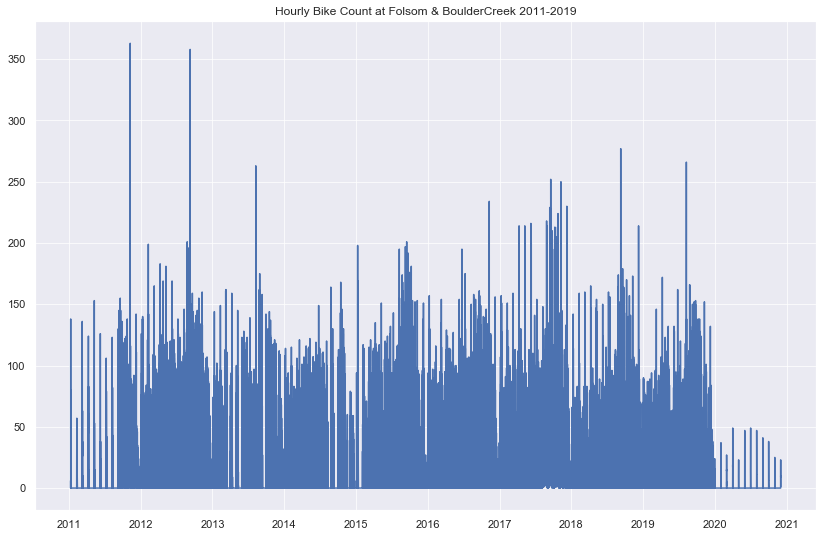

In [7]:
plt.plot(df_hourly_raw['ds'], df_hourly_raw['y'])

plt.title('Hourly Bike Count at Folsom & BoulderCreek 2011-2019')

plt.show()

Let's remove the first and last year as they are incomplete

In [8]:
df_hourly = df_hourly_raw[(df_hourly_raw['ds'].dt.year > 2011) & (df_hourly_raw['ds'].dt.year < 2019)]

df_hourly = df_hourly.reset_index(drop=True)

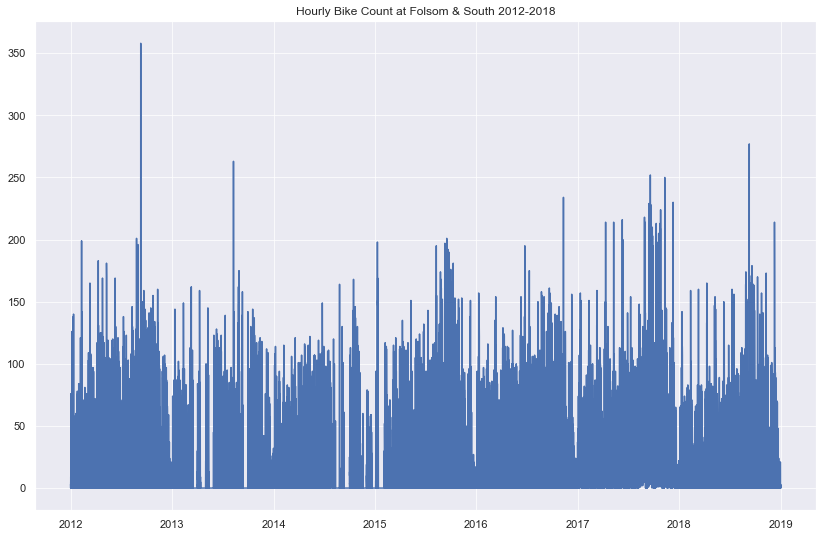

In [9]:
plt.plot(df_hourly['ds'], df_hourly['y'])

plt.title('Hourly Bike Count at Folsom & South 2012-2018')

plt.show()

In [10]:
# Calculate % of zeros in the data
zero_fs = df_hourly['y'].value_counts()[0] / len(df_hourly['y'])

print('Folsom & Boulder Creek hourly 0 count ratio: {:.4}%'.format(zero_fs * 100))

Folsom & Boulder Creek hourly 0 count ratio: 19.13%


Based on previous observations, I will remove 2013 and 2014 for the large amount of zero counts. For now, remove 2012 to keep a continuous time series

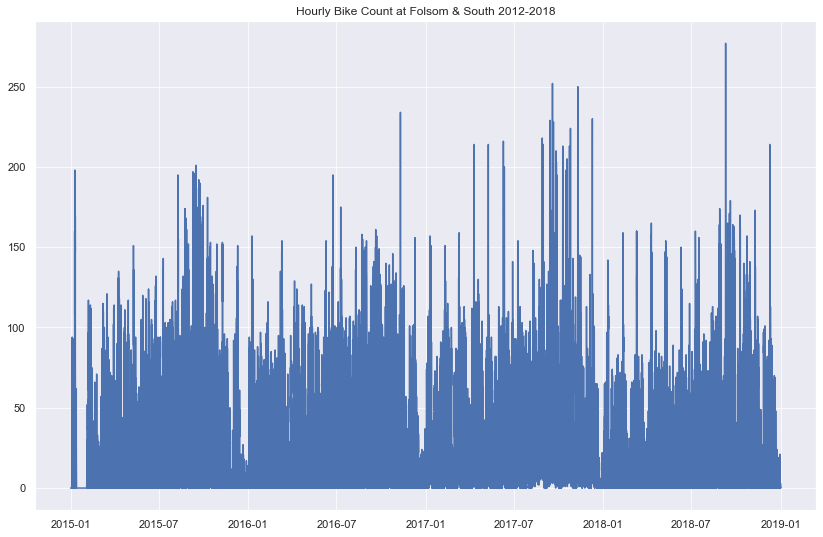

In [12]:
df_hourly = df_hourly[(df_hourly['ds'].dt.year >= 2015)]
df_hourly = df_hourly.reset_index(drop=True)

plt.plot(df_hourly['ds'], df_hourly['y'])

plt.title('Hourly Bike Count at Folsom & South 2012-2018')

plt.show()

That is much more consitant and shows a pretty clear yearly seasonality worth exploring. Let's remove the few outliers

## Filter Outliers

In [21]:
filtered_hourly = df_hourly.copy()

# Remove hourly counts that are more than 3 SD's out
sd = 3
filtered_hourly = filtered_hourly[(np.abs(stats.zscore(filtered_hourly['y'])) <= sd)]

removed = df_hourly.index.difference(filtered_hourly.index)
print('Removed {} hours.'.format(len(removed)))
print('Removed: {:.4}%'.format(len(df_hourly) / len(filtered_hourly)))
for i in removed:
    print(df_hourly.loc[i])

filtered_hourly = filtered_hourly.reset_index(drop=True)
filtered_hourly

Removed 520 hours.
Removed: 1.015%
ds    2015-01-09 08:00:00
y                     150
Name: 200, dtype: object
ds    2015-01-09 09:00:00
y                     160
Name: 201, dtype: object
ds    2015-01-09 13:00:00
y                     124
Name: 205, dtype: object
ds    2015-01-09 16:00:00
y                     154
Name: 208, dtype: object
ds    2015-01-09 17:00:00
y                     198
Name: 209, dtype: object
ds    2015-01-09 18:00:00
y                     150
Name: 210, dtype: object
ds    2015-01-10 16:00:00
y                     151
Name: 232, dtype: object
ds    2015-01-10 17:00:00
y                     147
Name: 233, dtype: object
ds    2015-01-10 18:00:00
y                     169
Name: 234, dtype: object
ds    2015-04-09 08:00:00
y                     131
Name: 2360, dtype: object
ds    2015-04-09 18:00:00
y                     135
Name: 2370, dtype: object
ds    2015-05-10 08:00:00
y                     151
Name: 3104, dtype: object
ds    2015-05-10 17:00:00
y           

Name: 22089, dtype: object
ds    2017-08-09 08:00:00
y                     148
Name: 22832, dtype: object
ds    2017-08-11 08:00:00
y                     140
Name: 22880, dtype: object
ds    2017-08-22 08:00:00
y                     130
Name: 23144, dtype: object
ds    2017-08-23 09:00:00
y                     125
Name: 23169, dtype: object
ds    2017-08-28 08:00:00
y                     218
Name: 23288, dtype: object
ds    2017-08-28 09:00:00
y                     167
Name: 23289, dtype: object
ds    2017-08-29 07:00:00
y                     142
Name: 23311, dtype: object
ds    2017-08-29 08:00:00
y                     183
Name: 23312, dtype: object
ds    2017-08-29 09:00:00
y                     180
Name: 23313, dtype: object
ds    2017-08-30 08:00:00
y                     214
Name: 23336, dtype: object
ds    2017-08-30 09:00:00
y                     166
Name: 23337, dtype: object
ds    2017-08-31 07:00:00
y                     126
Name: 23359, dtype: object
ds    2017-08-31 08:00:00

,ds,y
0,2015-01-01 00:00:00,0
1,2015-01-01 01:00:00,0
2,2015-01-01 02:00:00,0
3,2015-01-01 03:00:00,0
4,2015-01-01 04:00:00,0
...,...,...
34539,2018-12-31 19:00:00,0
34540,2018-12-31 20:00:00,0
34541,2018-12-31 21:00:00,0
34542,2018-12-31 22:00:00,0


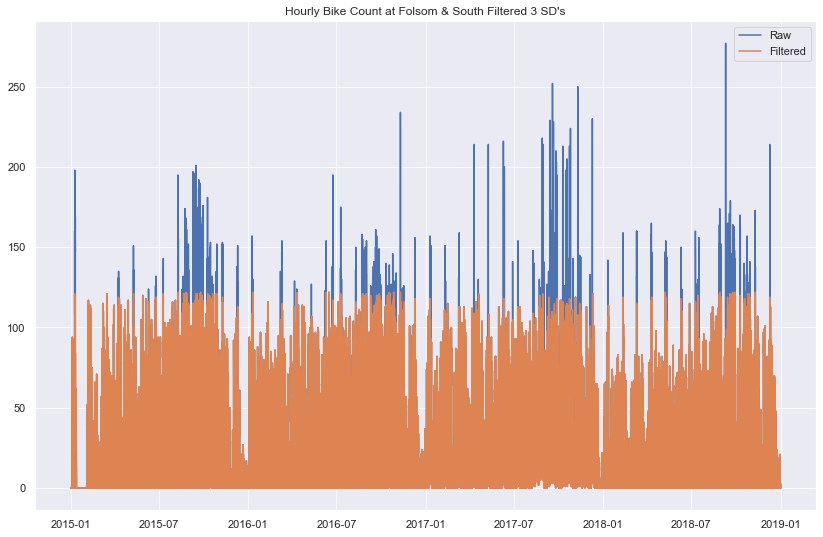

In [22]:
fig, ax = plt.subplots()

ax.plot(df_hourly['ds'], df_hourly['y'], label='Raw')
ax.plot(filtered_hourly['ds'], filtered_hourly['y'], label='Filtered')

plt.title("Hourly Bike Count at Folsom & South Filtered {} SD's".format(sd))
plt.legend(loc='upper right')

plt.show()

## Examining Auto Correlation

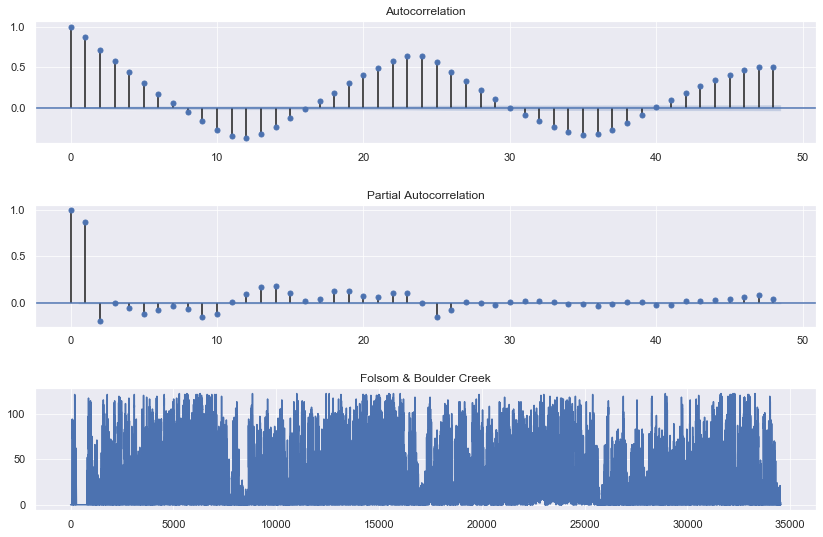

In [23]:
# Folsom & Boulder Creek Auto Correlation
a_lags = 48
p_lags = 48

fig, ax = plt.subplots(3)
plt.subplots_adjust(hspace=0.5)
plt.title('Folsom & Boulder Creek')

ax[0] = plot_acf(filtered_hourly['y'], ax=ax[0], lags=a_lags)
ax[1] = plot_pacf(filtered_hourly['y'], ax=ax[1], lags=p_lags)
ax[2] = plt.plot(filtered_hourly['y'])

plt.show()

There is clear auto correltation going on. The hourly counts are clearly correlated with previous counts and there is a clear daily seasonality. I am confident in moving forward with time series forecasting, focusing on daily seasonalities. It appears that the previous 3 hours will likely be a good metric for forecasting the next hour.

## Prophet Forecasting

In [14]:
# Returns a training period and actual observed values of future predictions
def get_training_predicted(df, n, p, mask):
    while(True):
        sample = df[mask].sample(1)

        if(df.index.isin([sample.index[0] + n + p]).any()):
            start = sample.index
            end = start + n
            training = df.iloc[start.values[0]:end.values[0]]
            predicted_actual = df.iloc[end.values[0]:(end+p).values[0]]
            return(training, predicted_actual)

In [15]:
# training_steps = numbers of time steps to train model on
# predicting_steps = number of time steps to predict
# data = data frame to train model 
# start_mask = Desired start time of the slice
training_steps = 216
predicting_steps = 24
data = filtered_hourly
start_mask = filtered_hourly['ds'].dt.hour == 0

# Get the training and predicting data
training, predicted_actual = get_training_predicted(data, training_steps, predicting_steps, start_mask)

print('Start Training: {}'.format(training['ds'].iloc[0]))
print('End Training: {}\n'.format(training['ds'].iloc[-1]))
print('Start Predicting: {}'.format(predicted_actual['ds'].iloc[0]))
print('End Predicting: {}'.format(predicted_actual['ds'].iloc[-1]))

INFO:numexpr.utils:NumExpr defaulting to 4 threads.


Start Training: 2018-02-11 00:00:00
End Training: 2018-02-19 23:00:00

Start Predicting: 2018-02-20 00:00:00
End Predicting: 2018-02-20 23:00:00


In [16]:
# Find the max hourly count for setting the cap on the logistic growth function
# Max = 286
# df_FS_hourly.max()

In [17]:
# Set the floor and cap for logistic growth
floor = 0
cap = 300

# training['floor'] = floor
# training['cap'] = cap

# Fit a model on Folsom & Pine Hourly counts
model = Prophet(seasonality_mode='multiplicative',
                daily_seasonality=5,
                weekly_seasonality=2,
                yearly_seasonality=False).fit(training)

In [18]:
# Create the future dataframe
future = model.make_future_dataframe(periods=predicting_steps, freq='H')

# future['floor'] = floor
# future['cap'] = cap

# Forecast on the model
forecast = model.predict(future)

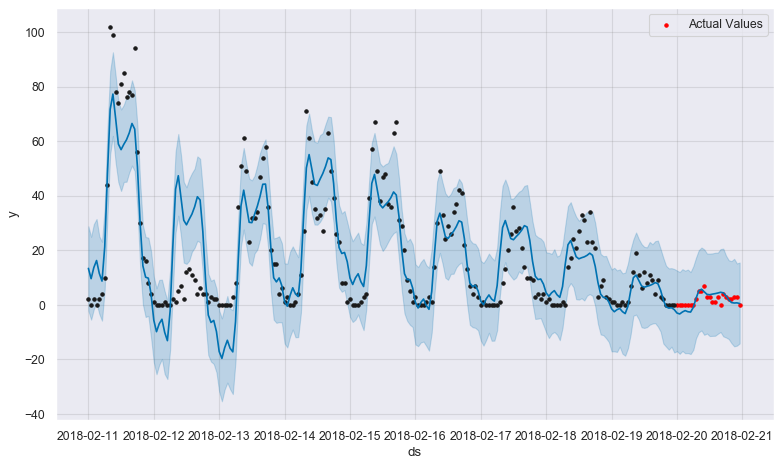

In [19]:
# Plot the forecast
fig = model.plot(forecast)
plt.scatter(predicted_actual['ds'], predicted_actual['y'], color='red', marker='.', label='Actual Values')
plt.legend(loc='upper right')

plt.show()

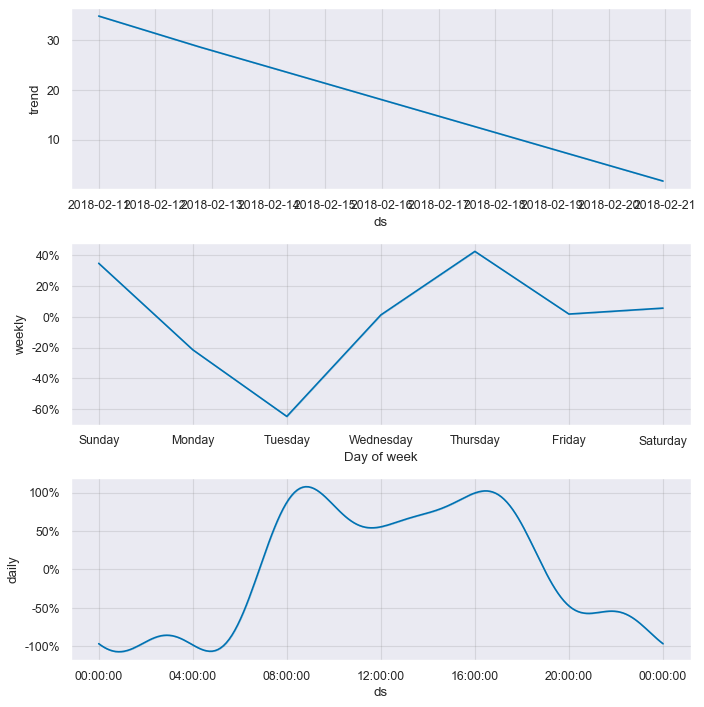

In [20]:
fig = model.plot_components(forecast)

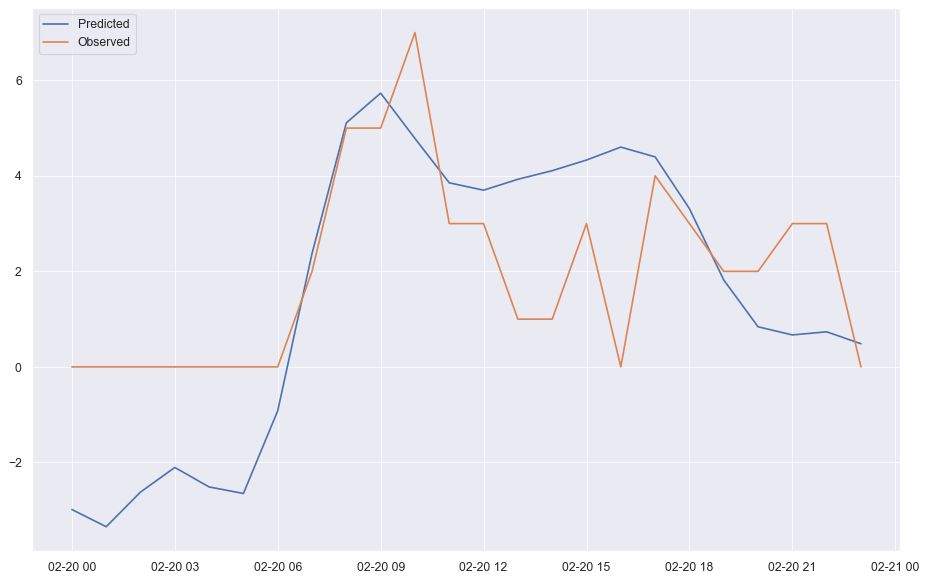

In [21]:
# Calculate residuals
predicted = forecast.tail(24)
predicted = predicted.reset_index()
observed = predicted_actual.reset_index()

residuals = observed['y'] - predicted['yhat']

x = predicted_actual['ds']

plt.plot(x, predicted['yhat'], label='Predicted')
plt.plot(x, observed['y'], label='Observed')

plt.legend(loc='upper left')

plt.show()

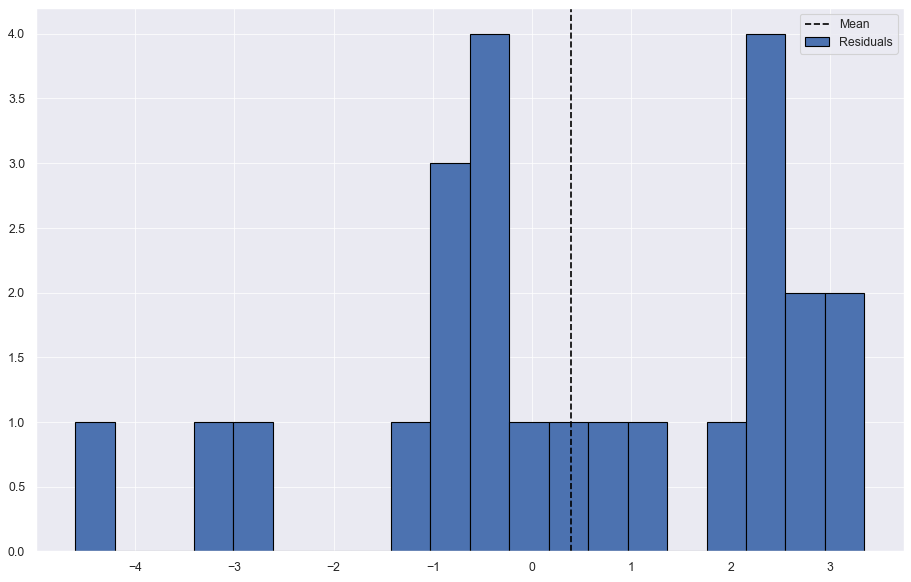

In [22]:
plt.hist(residuals, bins=20, edgecolor='black', label='Residuals')
plt.axvline(x=residuals.mean(), linestyle='--', color='black', label='Mean')

plt.legend(loc='upper right')

plt.show()

## Simulating Many Times - Extra Regressors

In [23]:
# Rename for join
df_weather.rename(columns= {'date': 'ds'}, inplace=True)

# Slice weather DF based on time range of daily data
weather_slice = df_weather[(df_weather['ds'] >= filtered_hourly['ds'].iloc[0]) & (df_weather['ds'] <= filtered_hourly['ds'].iloc[-1])]
weather_slice.reset_index(inplace=True, drop=True)

# New DF for regressor features
hourly_regressors = filtered_hourly.copy()

# Convert to datetime for consitancy
hourly_regressors['ds'] = pd.to_datetime(hourly_regressors['ds'])
weather_slice['ds'] = pd.to_datetime(weather_slice['ds'])

# Join
# hourly_regressors = hourly_regressors.merge(weather_slice, on='ds')

# Drop some features, can comment out to add them back
# ds, tmax, tmin, precip, snow, snowcover
# drop = ['tmin', 'precip','snow', 'snowcover']
# hourly_regressors = hourly_regressors.drop(columns=drop)
hourly_regressors

C:\Users\munoz\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  del sys.path[0]


,ds,y
0,2015-01-01 00:00:00,0
1,2015-01-01 01:00:00,0
2,2015-01-01 02:00:00,0
3,2015-01-01 03:00:00,0
4,2015-01-01 04:00:00,0
...,...,...
35007,2018-12-31 19:00:00,0
35008,2018-12-31 20:00:00,0
35009,2018-12-31 21:00:00,0
35010,2018-12-31 22:00:00,0


In [34]:
n = 5
observed = []
models = []
futures = []

training_steps = 72
predicting_steps = 24
data = filtered_hourly
start_mask = filtered_hourly['ds'].dt.hour == 0

# floor = 0 
# cap = 300

for i in range(n):
    testing, predicted = get_training_predicted(data, training_steps, predicting_steps, start_mask)
    
    # Adjust floor and cap values for "growth='logistic'"
#     t['floor'] = floor
#     t['cap'] = cap

    # Collect observed values 
    observed.append(predicted)
    
    m = Prophet(seasonality_mode='multiplicative',
               yearly_seasonality = False,
               weekly_seasonality = False,
               daily_seasonality = True)
    
    # Add regreossors indiviually
#     m.add_regressor('tmax', prior_scale=0.5)
    
    
    m.fit(testing)
    models.append(m)

    future = m.make_future_dataframe(predicting_steps, freq='H')
#     future = future.merge(weather_slice, on='ds')
#     future = future.drop(columns=drop)

    # Adjust floor and cap values for "growth='logistic'"
#     future['floor'] = floor
#     future['cap'] = cap

    forecast = m.predict(future)
    
    futures.append(forecast)

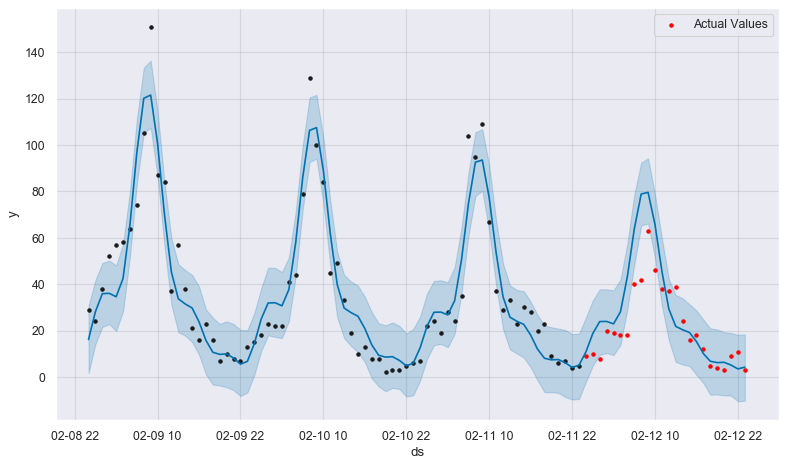

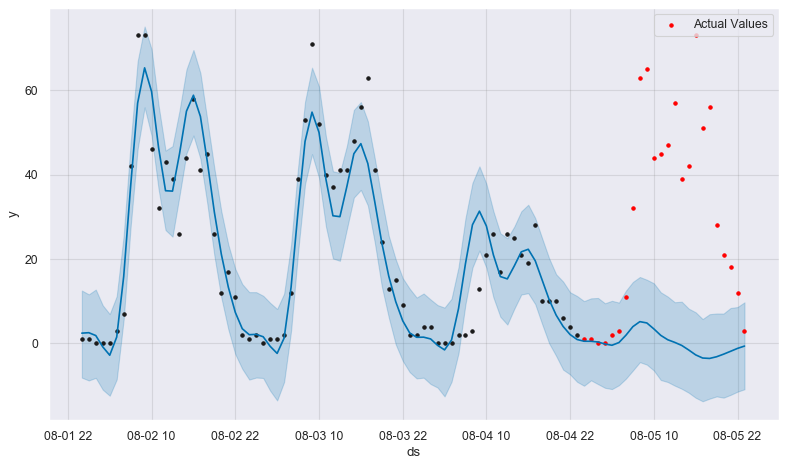

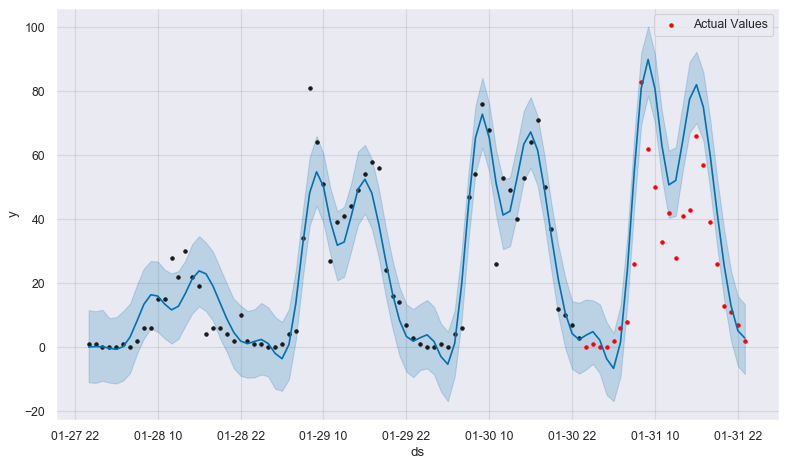

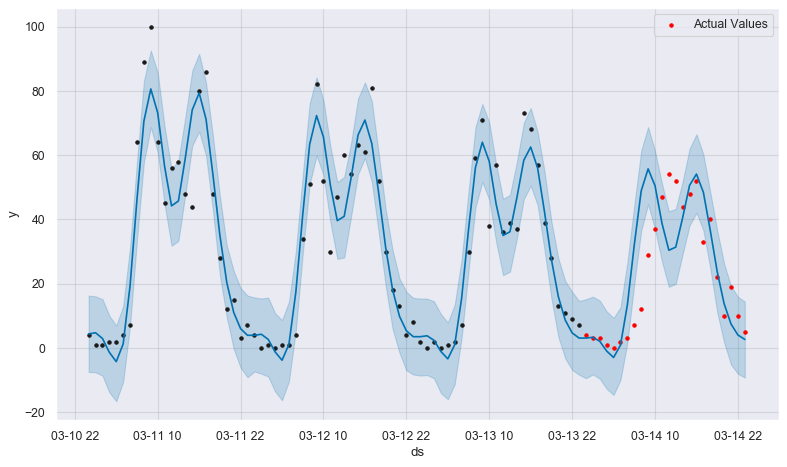

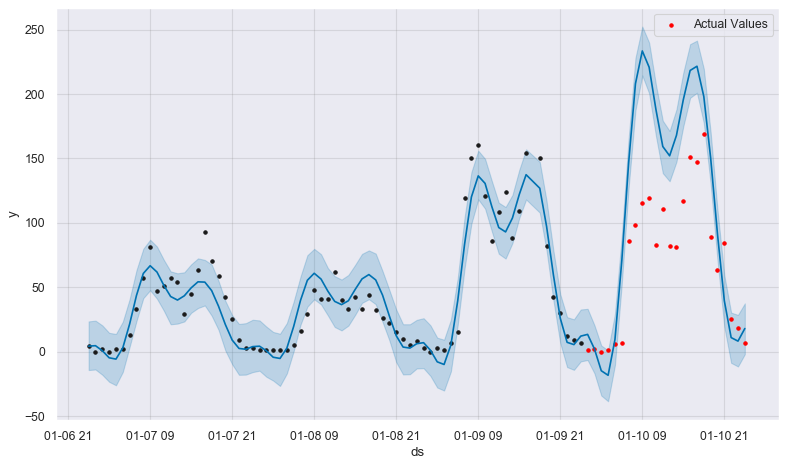

In [35]:
# Plot the forecast
for i in range(n):
    models[i].plot(futures[i])
    plt.scatter(observed[i]['ds'], observed[i]['y'], color='red', marker='.', label='Actual Values')
    
#     plt.xticks(rotation=315)
    plt.legend(loc='upper right')

# Daily Exploration

## Visualize Data

Text(0.5, 1.0, 'Daily Counts at Folsom & Boulder Creek 2015-2019')

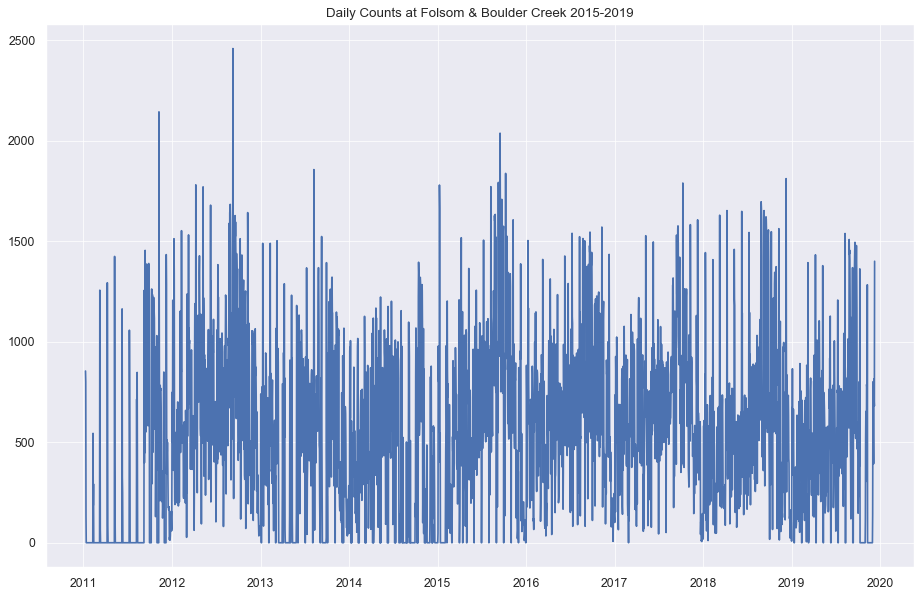

In [17]:
plt.plot(df_daily_raw['ds'], df_daily_raw['y'])

plt.title('Daily Counts at Folsom & Boulder Creek 2015-2019')

plt.show()

Let's remove the first year and incomplete final months of data for now.

In [18]:
df_daily = df_daily_raw[(df_daily_raw['ds'].dt.year > 2014) & (df_daily_raw['ds'].dt.year < 2019)]
df_daily.reset_index(inplace=True, drop=True)
df_daily

,ds,y
0,2015-01-01,0
1,2015-01-02,0
2,2015-01-03,47
3,2015-01-04,978
4,2015-01-05,813
...,...,...
1456,2018-12-27,163
1457,2018-12-28,123
1458,2018-12-29,99
1459,2018-12-30,102


Text(0.5, 1.0, 'Daily Counts at Folsom & Boulder Creek 2016-2018')

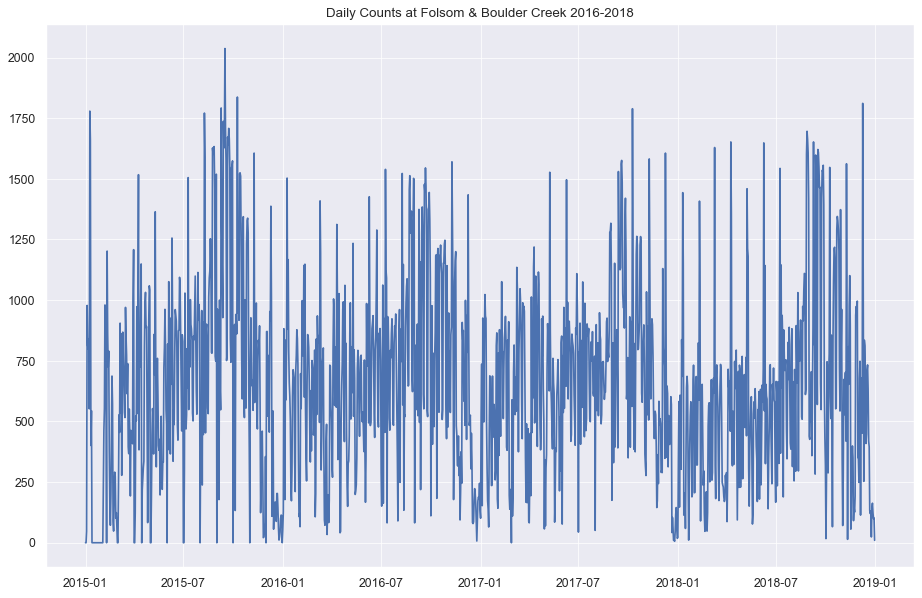

In [19]:
plt.plot(df_daily['ds'], df_daily['y'])

plt.title('Daily Counts at Folsom & Boulder Creek 2016-2018')

plt.show()

In [20]:
# Check for 0 counts
print(0 in df_daily['y'])

# Calculate number of zeros in the data
zero_fs = df_daily['y'].isin([0]).sum()
print(zero_fs)

print(df_daily.loc[df_daily['y'] == 0])

True
41
            ds  y
0   2015-01-01  0
1   2015-01-02  0
12  2015-01-13  0
13  2015-01-14  0
14  2015-01-15  0
15  2015-01-16  0
16  2015-01-17  0
17  2015-01-18  0
18  2015-01-19  0
19  2015-01-20  0
20  2015-01-21  0
21  2015-01-22  0
22  2015-01-23  0
23  2015-01-24  0
24  2015-01-25  0
25  2015-01-26  0
26  2015-01-27  0
27  2015-01-28  0
28  2015-01-29  0
29  2015-01-30  0
30  2015-01-31  0
31  2015-02-01  0
32  2015-02-02  0
39  2015-02-09  0
59  2015-03-01  0
60  2015-03-02  0
90  2015-04-01  0
91  2015-04-02  0
104 2015-04-15  0
120 2015-05-01  0
121 2015-05-02  0
151 2015-06-01  0
181 2015-07-01  0
182 2015-07-02  0
212 2015-08-01  0
243 2015-09-01  0
273 2015-10-01  0
304 2015-11-01  0
334 2015-12-01  0
364 2015-12-31  0
788 2017-02-27  0


There seems to be an issue with 2015, let's remove it 

In [21]:
df_daily = df_daily[df_daily['ds'].dt.year != 2015]
df_daily = df_daily.reset_index(drop=True)

# Check for 0 counts
print(0 in df_daily['y'])

# Calculate number of zeros in the data
zero_fs = df_daily['y'].isin([0]).sum()
print(zero_fs)

print(df_daily.loc[df_daily['y'] == 0])
df_daily

True
1
            ds  y
423 2017-02-27  0


,ds,y
0,2016-01-01,53
1,2016-01-02,128
2,2016-01-03,882
3,2016-01-04,731
4,2016-01-05,178
...,...,...
1091,2018-12-27,163
1092,2018-12-28,123
1093,2018-12-29,99
1094,2018-12-30,102


## Outlier Removal

In [22]:
filtered_daily = df_daily.copy()

# Remove hourly counts that are more than 3 SD's out
sd = 3
filtered_daily = filtered_daily[(np.abs(stats.zscore(filtered_daily['y'])) < sd)]

removed = df_daily.index.difference(filtered_daily.index)
print('Removed {} days.'.format(len(removed)))
for i in removed:
    print(df_daily.loc[i])

Removed 2 days.
ds    2017-10-09 00:00:00
y                    1789
Name: 647, dtype: object
ds    2018-12-09 00:00:00
y                    1811
Name: 1073, dtype: object


## Examining Autocorrelation

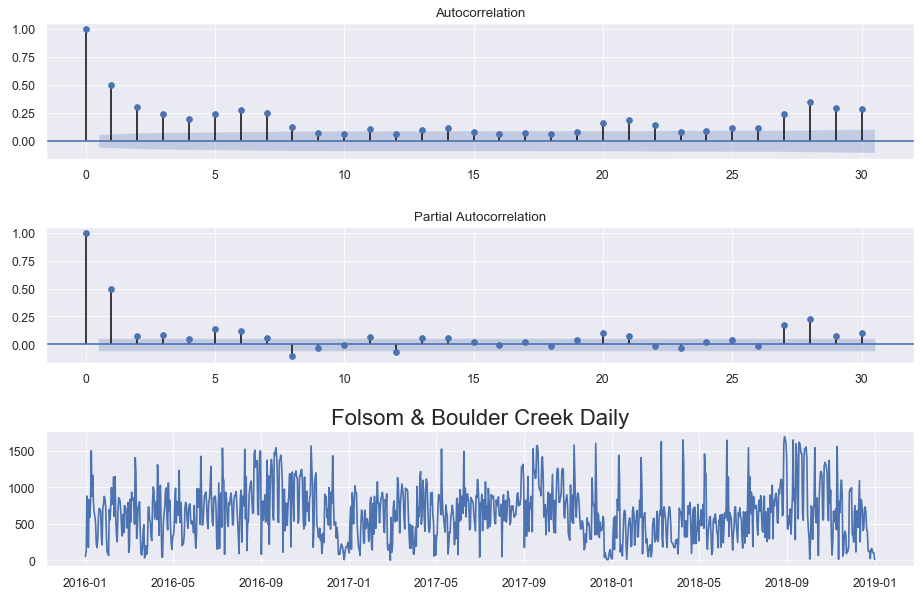

In [23]:
a_lags = 30
p_lags = 30
df = filtered_daily

fig, ax = plt.subplots(3)
plt.subplots_adjust(hspace=0.5)
plt.title('Folsom & Boulder Creek Daily', fontsize=20)

ax[0] = plot_acf(df['y'], ax=ax[0], lags=a_lags)
ax[1] = plot_pacf(df['y'], ax=ax[1], lags=p_lags)
ax[2] = plt.plot(df['ds'], df['y'])

plt.show()

In [24]:
## Something else

Text(0, 0.5, 'Count')

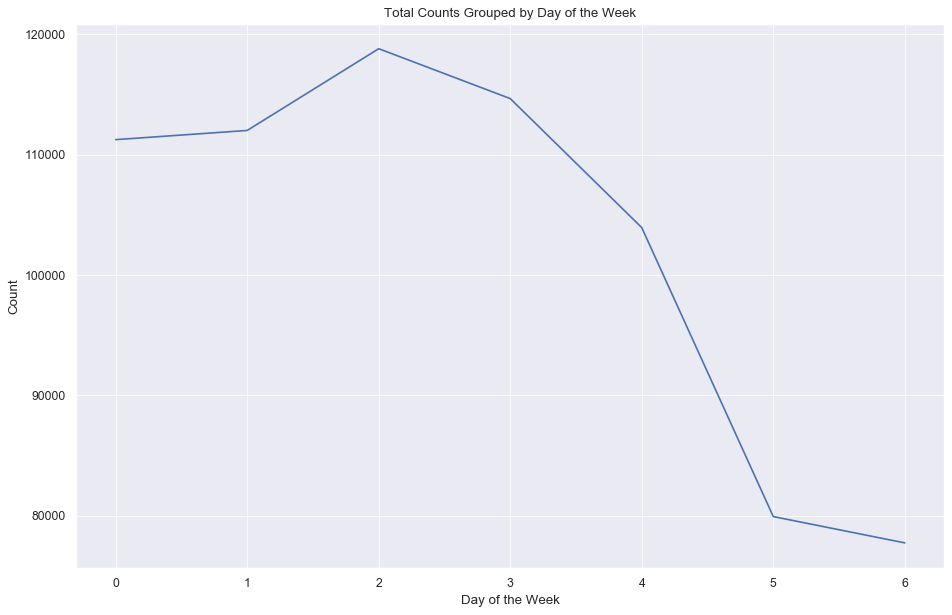

In [25]:
tmp = filtered_daily.copy()
tmp['day'] = tmp['ds'].dt.dayofweek
plt.plot(tmp.groupby(by='day')['y'].sum())

plt.title('Total Counts Grouped by Day of the Week')
plt.xlabel('Day of the Week')
plt.ylabel('Count')

plt.show()

## Prophet Forecasting

In [35]:
split_year = 2017
df = filtered_daily
training = df[df['ds'].dt.year <= split_year]
testing = df[df['ds'].dt.year > split_year]

print(training.tail())
print(testing.head())

            ds    y
726 2017-12-27   45
727 2017-12-28  117
728 2017-12-29  145
729 2017-12-30   55
730 2017-12-31   18
            ds    y
731 2018-01-01   23
732 2018-01-02  348
733 2018-01-03  582
734 2018-01-04  147
735 2018-01-05  608


In [36]:
m = Prophet(changepoint_prior_scale=0.1, seasonality_mode='multiplicative',
           yearly_seasonality = True,
           weekly_seasonality = True,
           daily_seasonality = False).fit(training)

In [37]:
future = m.make_future_dataframe(periods=len(testing), freq='1D')
future.tail()

,ds
1089,2018-12-26
1090,2018-12-27
1091,2018-12-28
1092,2018-12-29
1093,2018-12-30


In [38]:
forecast = m.predict(future)

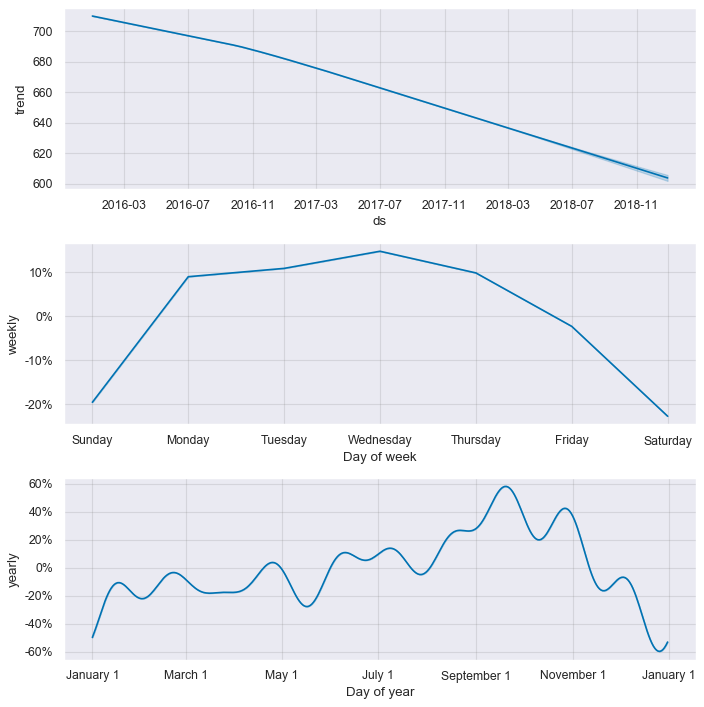

In [39]:
f = m.plot_components(forecast)

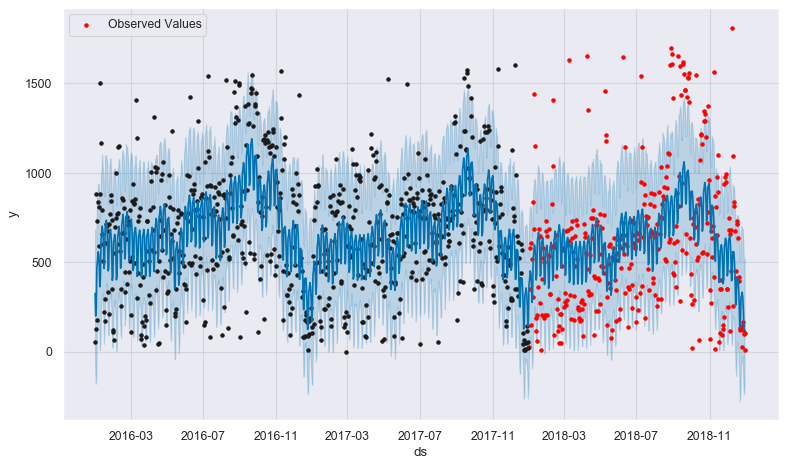

In [40]:
# Plot the forecast
fig = m.plot(forecast)
plt.scatter(df_daily['ds'][df_daily['ds'].dt.year == 2018], df_daily['y'][df_daily['ds'].dt.year == 2018], color='red', marker='.', label='Observed Values')
plt.legend(loc='upper left')

plt.show()

In [41]:
df_cv = cross_validation(m, initial='365.25 days', period='7 days', horizon = '100 days')
df_cv.head()

INFO:fbprophet:Making 38 forecasts with cutoffs between 2017-01-06 00:00:00 and 2017-09-22 00:00:00


,ds,yhat,yhat_lower,yhat_upper,y,cutoff
0,2017-01-07,618.415987,232.439167,1003.643211,498,2017-01-06
1,2017-01-08,711.215359,328.943276,1091.615768,834,2017-01-06
2,2017-01-09,1122.250598,716.698135,1521.062683,1023,2017-01-06
3,2017-01-10,1177.380805,794.273066,1541.291981,934,2017-01-06
4,2017-01-11,1281.636411,890.452427,1655.749907,924,2017-01-06


In [42]:
df_cv[['yhat', 'y']].corr()

,yhat,y
yhat,1.000000,0.360263
y,0.360263,1.000000


In [43]:
df_p = performance_metrics(df_cv)
df_p.head(25)

INFO:fbprophet:Skipping MAPE because y close to 0


,horizon,mse,rmse,mae,coverage
0,10 days,104594.833561,323.411245,240.354581,0.778613
1,11 days,112842.855881,335.920907,249.551740,0.760234
2,12 days,114947.965641,339.039770,253.101391,0.752437
3,13 days,117864.386051,343.313830,257.766739,0.739209
4,14 days,118087.525095,343.638655,258.169691,0.739209
5,15 days,118474.549861,344.201322,257.485240,0.745196
6,16 days,114294.387207,338.074529,251.614080,0.757728
7,17 days,113512.827495,336.916648,252.051033,0.757240
8,18 days,117481.934197,342.756377,255.416706,0.749304
9,19 days,117572.483257,342.888441,255.996507,0.746589


## Extra Regressors

### Add day of the week as feature

In [44]:
# 0-Monday, 1-Tuesday, 2-Wednesday, 3-Thursday, 4-Friday, 5-Saturday, 6-Sunday
filtered_daily['dayofweek'] = filtered_daily['ds'].dt.dayofweek

In [45]:
# Rename for join
df_weather = df_weather.rename(columns= {'date': 'ds'})

# Slice weather DF based on time range of daily data
weather_slice = df_weather[(df_weather['ds'] >= df_daily['ds'].iloc[0]) & (df_weather['ds'] <= df_daily['ds'].iloc[-1])]
weather_slice.reset_index(inplace=True, drop=True)

# New DF for regressor features
df_daily_regressors = filtered_daily.copy()

# Convert to datetime for consitancy
df_daily_regressors['ds'] = pd.to_datetime(df_daily_regressors['ds'])
weather_slice['ds'] = pd.to_datetime(weather_slice['ds'])

# Join
df_daily_regressors = df_daily_regressors.merge(weather_slice, on='ds')

# Drop some features, can comment out to add them back
# Features: tmax, tmin, snow, precip, snowcover, dayofweek
drop = ['tmin', 'snow', 'precip', 'snowcover']
df_daily_regressors = df_daily_regressors.drop(columns=drop)
df_daily_regressors

C:\Users\munoz\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  del sys.path[0]


,ds,y,dayofweek,tmax
0,2016-01-01,53,4,39
1,2016-01-02,128,5,46
2,2016-01-03,882,6,50
3,2016-01-04,731,0,45
4,2016-01-05,178,1,51
...,...,...,...,...
1089,2018-12-27,163,3,34
1090,2018-12-28,123,4,23
1091,2018-12-29,99,5,37
1092,2018-12-30,102,6,50


## Forecasting

In [46]:
split_year = 2017
training = df_daily_regressors[df_daily_regressors['ds'].dt.year <= split_year]
testing = df_daily_regressors[df_daily_regressors['ds'].dt.year > split_year]

print(training.tail())
print(testing.head())

            ds    y  dayofweek  tmax
725 2017-12-27   45          2    52
726 2017-12-28  117          3    51
727 2017-12-29  145          4    63
728 2017-12-30   55          5    53
729 2017-12-31   18          6    27
            ds    y  dayofweek  tmax
730 2018-01-01   23          0    30
731 2018-01-02  348          1    46
732 2018-01-03  582          2    50
733 2018-01-04  147          3    52
734 2018-01-05  608          4    62


In [47]:
m = Prophet(changepoint_prior_scale=0.1, seasonality_mode='multiplicative',
           yearly_seasonality = 15,
           weekly_seasonality = 8,
           daily_seasonality = False)

In [48]:
m.add_regressor('tmax', prior_scale=0.5)
# m.add_regressor('precip', prior_scale=0.5)
m.add_regressor('dayofweek', prior_scale=0.5)
# m.add_regressor('snowcover', prior_scale=0.5)

In [49]:
m.fit(training)

In [50]:
future = m.make_future_dataframe(periods=len(testing), freq='1D')
future = future.merge(weather_slice, on='ds')
future = future.drop(columns=drop)

future['dayofweek'] = df_daily_regressors['dayofweek']
future

,ds,tmax,dayofweek
0,2016-01-01,39,4
1,2016-01-02,46,5
2,2016-01-03,50,6
3,2016-01-04,45,0
4,2016-01-05,51,1
...,...,...,...
1089,2018-12-26,40,3
1090,2018-12-27,34,4
1091,2018-12-28,23,5
1092,2018-12-29,37,6


In [51]:
forecast = m.predict(future)

In [52]:
# Clip negative values
forecast.loc[:,'yhat'] = forecast['yhat'].clip(lower=0)
forecast.loc[:, 'yhat_lower'] = forecast['yhat_lower'].clip(lower=0)

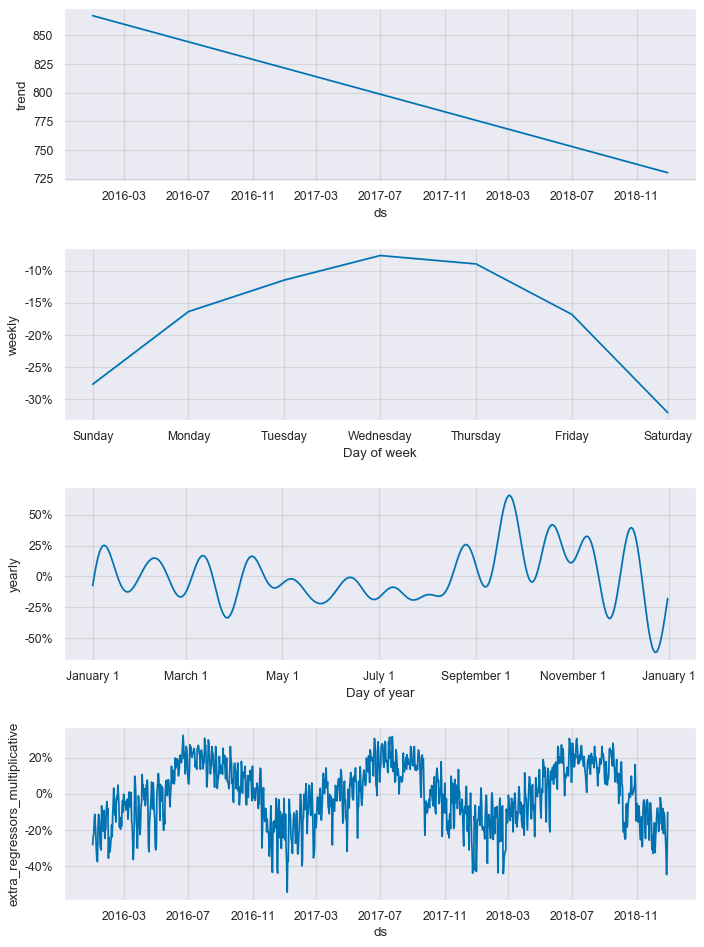

In [53]:
f = m.plot_components(forecast)

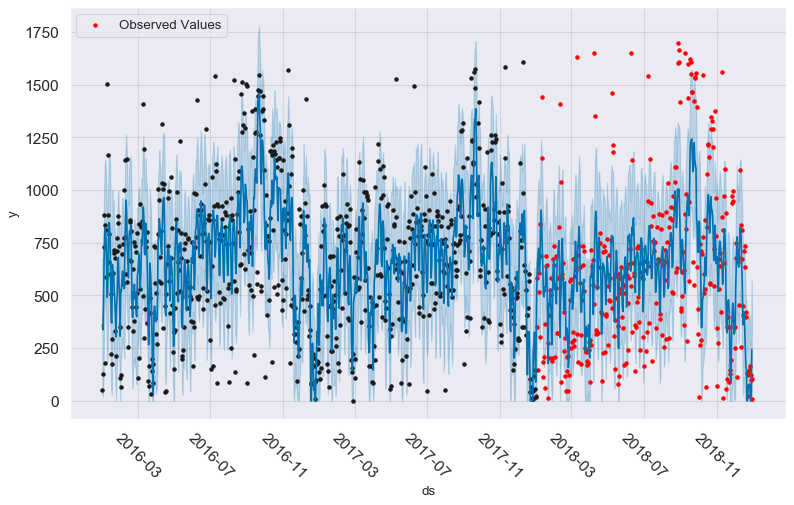

In [54]:
# Plot the forecast
fig = m.plot(forecast)
plt.scatter(df_daily_regressors['ds'][df_daily_regressors['ds'].dt.year == 2018], df_daily_regressors['y'][df_daily_regressors['ds'].dt.year == 2018], color='red', marker='.', label='Observed Values')
plt.xticks(rotation=315, fontsize=14)
plt.yticks(fontsize=14)
plt.legend(loc='upper left', fontsize=12)

plt.show()

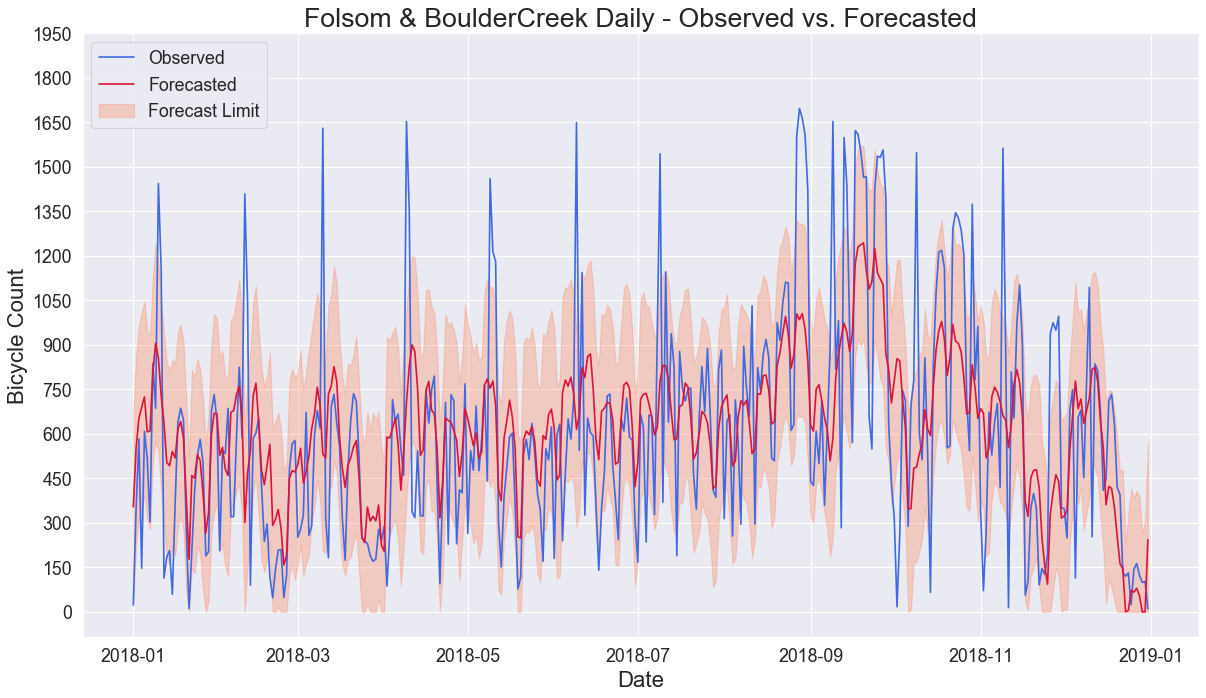

In [55]:
year = 2018
x = df_daily_regressors[df_daily_regressors['ds'].dt.year == year]['ds']
y_o = df_daily_regressors[df_daily_regressors['ds'].dt.year == year]['y']
y_f = forecast[forecast['ds'].dt.year == year]['yhat']
y_lower = forecast[forecast['ds'].dt.year == year]['yhat_lower']
y_upper = forecast[forecast['ds'].dt.year == year]['yhat_upper']

fig = plt.subplots(figsize=(18,10))
plt.plot(x, y_o, color='royalblue', label='Observed')
plt.plot(x, y_f, color='crimson', label='Forecasted')
plt.fill_between(x, y_lower, y_upper, color='coral', alpha=0.3, label='Forecast Limit')

y_ticks = np.arange(0, 2000, step=150)

plt.yticks(y_ticks, fontsize=16)
plt.xticks(fontsize=16)

plt.title('Folsom & BoulderCreek Daily - Observed vs. Forecasted', fontsize=24)
plt.xlabel('Date', fontsize=20)
plt.ylabel('Bicycle Count', fontsize=20)
plt.legend(loc='upper left', fontsize=16)

plt.show()

In [56]:
residuals = df_daily_regressors['y'] - forecast['yhat']

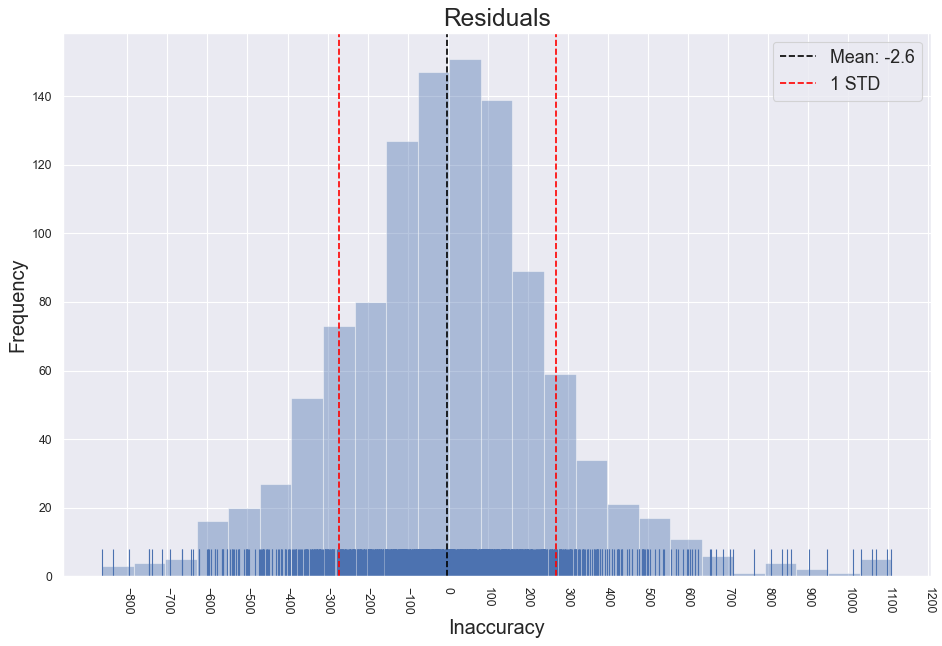

In [57]:
fig = sns.distplot(residuals, bins=25, kde=False, rug=True)

fig.axvline(x=residuals.mean(), color='black', linestyle='--', label='Mean: {:.2}'.format(residuals.mean()))
std = np.std(residuals)
fig.axvline(x=std, color='red', linestyle='--', label='1 STD')
fig.axvline(x=-std, color='red', linestyle='--')

x_ticks = np.arange(-800, 1300, step=100)
plt.xticks(x_ticks, rotation=270)

plt.grid(alpha=1)

plt.title('Residuals', fontsize=22)
plt.xlabel('Inaccuracy', fontsize=18)
plt.ylabel('Frequency', fontsize=18)
plt.legend(loc='upper right', fontsize=16)

plt.show()

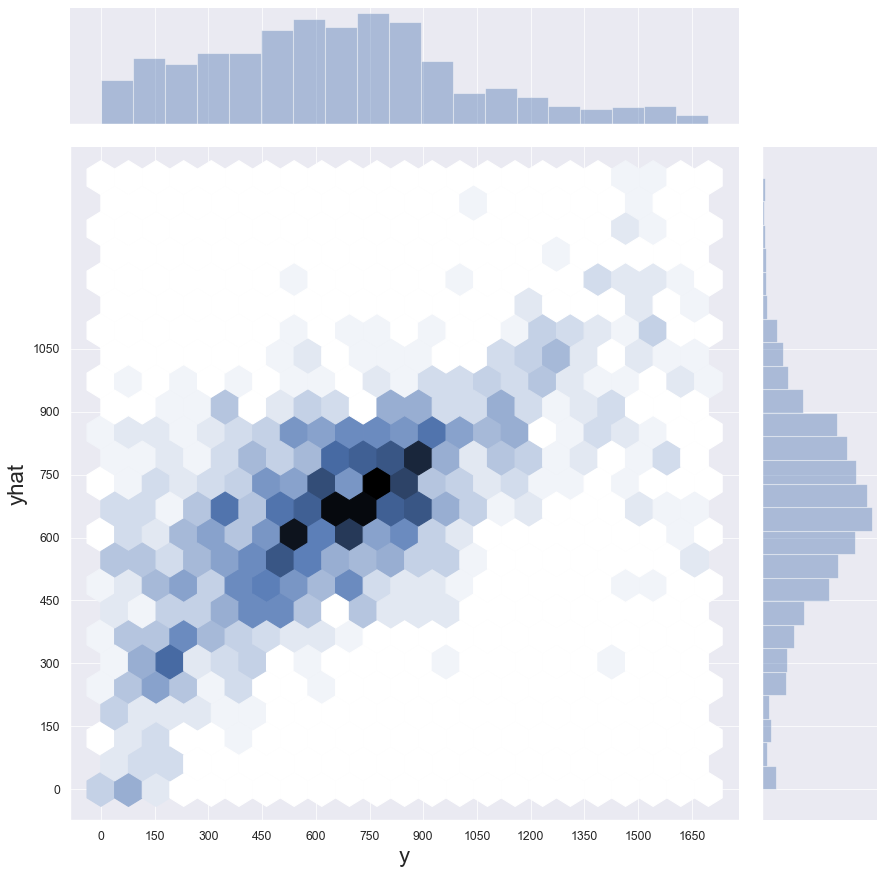

In [58]:
fig = sns.jointplot(x=df_daily_regressors['y'], y=forecast['yhat'], kind="hex", height=11)

fig.set_axis_labels('y', 'yhat', fontsize=20)

fig.ax_joint.set_yticks(np.arange(0, 1200, 150))
fig.ax_joint.set_xticks(np.arange(0, 1800, 150))

sns.set(font_scale=1.5)

plt.show()

In [59]:
np.corrcoef(df_daily_regressors['y'], forecast['yhat'])

array([[1.        , 0.67069561],
       [0.67069561, 1.        ]])

In [86]:
# df_cv = cross_validation(m, initial='365.25 days', period='180 days', horizon = '365 days')
# df_cv.head()

In [72]:
# df_p = performance_metrics(df_cv)
# df_p.head()

In [62]:
# fig = plot_cross_validation_metric(df_cv, metric='rmse')

In [90]:
from sklearn.metrics import mean_squared_error
y = df_daily_regressors['y']
yhat = forecast['yhat']

# MSE
mse = mean_squared_error(y, yhat)
print(mse)

# RMSE
rmse = np.sqrt(mse)
print(rmse)

73388.48286130559
270.9030875817136
